In [1]:
import torch
import cPickle as pickle
from tqdm import tqdm
import ConfigParser
from time import time
from nltk.tokenize import RegexpTokenizer
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
stop = set(stopwords.words('english'))

In [2]:
###################################################################
config = ConfigParser.ConfigParser()
config.readfp(open(r'../src/config.ini'))

SAVE_PATH = config.get('paths', 'save_path')
DATA_FILE_NAME = config.get('paths', 'extracted_data_file_name')
filename = SAVE_PATH + DATA_FILE_NAME

In [3]:
tic1 = time()
with open(filename) as f:  # Python 3: open(..., 'rb')
    train_text_df, train_idx_df, dev_idx_df, test_idx_df, embeddings, word_to_idx = pickle.load(f)
toc1 = time()
print "elapsed time to retrieve extracted data from file: %.2f sec" %(toc1 - tic1)

elapsed time to retrieve extracted data from file: 19.38 sec


In [ ]:
train_text_df.describe()

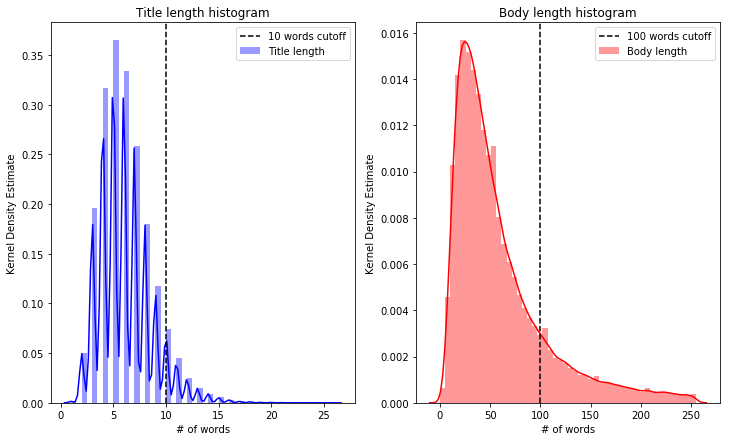

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
MAX_TITLE_LEN = 10
MAX_BODY_LEN = 100 
#visualize data
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
sns.distplot(train_text_df['title_len'], hist=True, kde=True, color='b', label='Title length', ax=ax1)
sns.distplot(train_text_df[train_text_df['body_len'] < 256]['body_len'], hist=True, kde=True, color='r', label='Body length', ax=ax2)

ax1.axvline(x=MAX_TITLE_LEN, color='k', linestyle='--', label='10 words cutoff')
ax2.axvline(x=MAX_BODY_LEN, color='k', linestyle='--', label='100 words cutoff')
ax1.set_title('Title length histogram'); ax1.legend(loc=1); 
ax2.set_title('Body length histogram'); ax2.legend(loc=1);
ax1.set_xlabel("# of words")
ax2.set_xlabel("# of words")
ax1.set_ylabel("Kernel Density Estimate")
ax2.set_ylabel("Kernel Density Estimate")
plt.show()
#plt.savefig('./figures/question_len_hist.png')

In [5]:


print "loading data..."
tic = time()
DATA_PATH_TARGET = config.get('paths', 'data_path_target')
target_text_file = DATA_PATH_TARGET + '/corpus.txt'
target_text_df = pd.read_table(target_text_file, sep='\t', header=None)
target_text_df.columns = ['id', 'title', 'body']

target_text_df = target_text_df.dropna()
target_text_df['titles'] = target_text_df['title'].apply(lambda words: ' '.join(filter(lambda x: x not in stop, words.split())))
target_text_df['bodys'] = target_text_df['body'].apply(lambda words: ' '.join(filter(lambda x: x not in stop, words.split())))
target_text_df['title_len'] = target_text_df['titles'].apply(lambda words: len(tokenizer.tokenize(str(words))))
target_text_df['body_len'] = target_text_df['bodys'].apply(lambda words: len(tokenizer.tokenize(str(words))))
target_text_df['title_len_or'] = target_text_df['title'].apply(lambda words: len(tokenizer.tokenize(str(words))))
target_text_df['body_len_or'] = target_text_df['body'].apply(lambda words: len(tokenizer.tokenize(str(words))))


target_pos_file = DATA_PATH_TARGET + '/test.pos.txt'
target_pos_df = pd.read_table(target_pos_file, sep=' ', header=None)
target_pos_df.columns = ['id_1', 'id_2']

target_neg_file = DATA_PATH_TARGET + '/test.neg.txt'
target_neg_df = pd.read_table(target_neg_file, sep=' ', header=None)
target_neg_df.columns = ['id_1', 'id_2']
toc = time()
print "elapsed time: %.2f sec" %(toc - tic)


loading data...
elapsed time: 3.25 sec


In [ ]:
print target_text_df.describe()
print target_pos_df.describe()
print target_neg_df.describe()

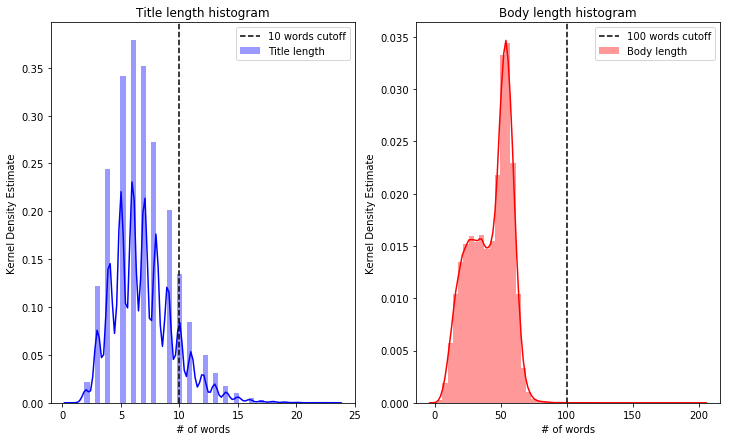

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
MAX_TITLE_LEN = 10
MAX_BODY_LEN = 100 
#visualize data
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
sns.distplot(target_text_df['title_len'], hist=True, kde=True, color='b', label='Title length', ax=ax1)
sns.distplot(target_text_df['body_len'], hist=True, kde=True, color='r', label='Body length', ax=ax2)

ax1.axvline(x=MAX_TITLE_LEN, color='k', linestyle='--', label='10 words cutoff')
ax2.axvline(x=MAX_BODY_LEN, color='k', linestyle='--', label='100 words cutoff')
ax1.set_title('Title length histogram'); ax1.legend(loc=1); 
ax2.set_title('Body length histogram'); ax2.legend(loc=1);
ax1.set_xlabel("# of words")
ax2.set_xlabel("# of words")
ax1.set_ylabel("Kernel Density Estimate")
ax2.set_ylabel("Kernel Density Estimate")
plt.show()
#plt.savefig('./figures/question_len_hist.png')

In [ ]:














#model parameters
embed_dim = embeddings.shape[1] #200
hidden_size = 128 #hidden vector dim 
weight_decay = 1e-5 
learning_rate = 1e-3
class  CNN(nn.Module):
    def __init__(self, embed_num, embed_dim, kernel_num, kernel_sizes):
        super(CNN,self).__init__()
        V = embed_num
        D = embed_dim
        Ci = 1            #input channel
        Co = kernel_num   #depth
        Ks = kernel_sizes #height of each filter

        self.embed = nn.Embedding(V, D)
        self.embed.weight.data = torch.from_numpy(embeddings)
        self.convs1 = nn.ModuleList([nn.Conv2d(Ci, Co, (K, D)) for K in Ks])

    def forward(self, x, flg):
        print "--\n input\n--\n"
        print x.data.shape
        x = self.embed(x) # (N,W,D)
        print "--\n after embed\n--\n"
        print x.data.shape
        x = x.unsqueeze(1) # (N,Ci,W,D)
        print "--\n after unsqueeze\n--\n"
        print x.data.shape
        
        for conv in self.convs1:
            conv(x)
        
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] #[(N,Co,W), ...]*len(Ks)
        print "--\n RELU\n--\n"
        for t in x:
            print t.data.shape
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x] #[(N,Co), ...]*len(Ks)
        print "--\n after maxpool\n--\n"
        for t in x:
            print t.data.shape
        x = torch.cat(x, 1)
        print "--\n after concat\n--\n"
        print x.data.shape
        return x

batch_size = 32
embed_num = len(word_to_idx)
embed_dim = len(embeddings[0])
kernel_num = 100  
kernel_sizes = range(2,6)
model = CNN(embed_num, embed_dim, kernel_num, kernel_sizes)
print model

In [ ]:
#m = nn.AvgPool1d(3, stride=1)
x = torch.Tensor([[[20, 30]]])
m = [nn.AvgPool1d(i, i.size(2)).squeeze(2) for i in x]
m(Variable(torch.Tensor([[[1,2,3,4,5,6,7]]])))

In [ ]:

print "training..."
for epoch in range(2):
    
    running_train_loss = 0.0
    
    train_data_loader = torch.utils.data.DataLoader(
        train_data, 
        batch_size = batch_size,
        shuffle = True,
        num_workers = 4, 
        drop_last = True)
        
    model.train()
    scheduler.step()
        
    for batch in tqdm(train_data_loader):
    
        query_title = Variable(batch['query_title'])
        query_body = Variable(batch['query_body'])        
        optimizer.zero_grad()
        print query_title.data.shape
        cnn_query_title = model(query_title, 0)
        sys.exit(0)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.autograd as autograd
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR

import ConfigParser
from tqdm import tqdm
from time import time
import cPickle as pickle
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from ranking_metrics import compute_mrr, precision_at_k, compute_map

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
np.random.seed(0)
from operator import itemgetter, attrgetter
from sklearn.metrics.pairwise import cosine_similarity
from meter import AUCMeter
#torch.manual_seed(0)

In [ ]:
config = ConfigParser.ConfigParser()
config.readfp(open(r'../src/config.ini'))
SAVE_PATH = config.get('paths', 'save_path')
DATA_FILE_NAME = config.get('paths', 'extracted_data_file_name')
TRAIN_TEST_FILE_NAME = config.get('paths', 'train_test_file_name')
SAVE_NAME = config.get('cnn_params', 'save_name')
NUM_NEGATIVE = int(config.get('data_params', 'NUM_NEGATIVE')) 
DATA_PATH_TARGET = config.get('paths', 'data_path_target')
MAX_TITLE_LEN = int(config.get('data_params', 'MAX_TITLE_LEN'))
MAX_BODY_LEN = int(config.get('data_params', 'MAX_BODY_LEN'))

data_filename = SAVE_PATH + DATA_FILE_NAME
train_test_filename = SAVE_PATH + TRAIN_TEST_FILE_NAME

In [ ]:
'''
class  CNN(nn.Module):
    def __init__(self, embed_num, embed_dim, kernel_num, kernel_sizes):
        super(CNN,self).__init__()
        V = embed_num
        D = embed_dim
        Ci = 1            #input channel
        Co = kernel_num   #depth
        Ks = kernel_sizes #height of each filter

        self.embed = nn.Embedding(V, D)
        self.embed.weight.data = torch.from_numpy(embeddings)
        self.convs1 = nn.ModuleList([nn.Conv2d(Ci, Co, (K, D)) for K in Ks])

    def forward(self, x):
        x = self.embed(x) # (N,W,D)
        x = x.unsqueeze(1) # (N,Ci,W,D)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] #[(N,Co,W), ...]*len(Ks)
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x] #[(N,Co), ...]*len(Ks)
        x = torch.cat(x, 1)
        return x

#CNN parameters
batch_size = 32
embed_num = len(word_to_idx)
embed_dim = len(embeddings[0])
kernel_num = 100  
kernel_sizes = range(2,6)
model = CNN(embed_num, embed_dim, kernel_num, kernel_sizes)
'''

In [ ]:
model1 = torch.load("../trained_models/cnn_baseline_full_40neg.pt")

In [ ]:
train_text_df['title_body'] = train_text_df['title'] + " " + train_text_df['body']

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.8, max_features=None,
                                 min_df=2, stop_words='english', strip_accents = 'ascii',
                             )

In [ ]:
vec_obj = vectorizer.fit(train_text_df['title_body'].tolist())

In [ ]:
target_text_file = DATA_PATH_TARGET + 'corpus.txt'
target_text_df = pd.read_table(target_text_file, sep='\t', header=None)
target_text_df.columns = ['id', 'title', 'body']


In [ ]:
def get_similarity(embed1, embed2):
    # embed1, embed2 could be tf-idf vectors, word embeddings, anything.
    return cosine_similarity(embed1, embed2)

def process_file(query_id_path, text_pd, vectorizer, ground_truth):
    similarity_vector = []
    ground_truth_arr = []
    
    data_frame = pd.read_table(query_id_path, sep=' ', header=None)
    data_frame.columns = ['query_id', 'candidate_id']
    
    #num_samples = min(100,data_frame.shape[0])
    num_samples = data_frame.shape[0]
    for idx in tqdm(range(num_samples)):
        #try:
            ind1 = np.where(text_pd['idz'] == data_frame.loc[idx,'query_id'])
            ind2 = np.where(text_pd['idz'] == data_frame.loc[idx,'candidate_id'])
            ind1 = int(ind1[0])
            ind2 = int(ind2[0])
            q1 = text_pd.loc[ind1,'body']
            q2 = text_pd.loc[ind2,'body']
            s = get_similarity(vectorizer.transform([q1]),vectorizer.transform([q2]))
            similarity_vector.append(float(s[0][0]))
            ground_truth_arr.append(ground_truth)
        #except:
         #    print "oopsie1" 
            
        
    return similarity_vector, ground_truth_arr


In [ ]:
text_pd = pd.read_table(DATA_PATH_TARGET + 'corpus.txt', sep='\t', header=None)
text_pd.columns = ['idz', 'text','body']
text_pd['body'] = text_pd['text'] + " " + text_pd['body']
text_pd = text_pd.dropna()
text_pd = text_pd.reset_index()

In [ ]:
auc_obj = AUCMeter()
target_dev_neg = DATA_PATH_TARGET + 'test.neg.txt'
sim_dev_neg, ground_truth_neg = process_file(target_dev_neg, text_pd, vectorizer, 0)

target_dev_pos = DATA_PATH_TARGET + 'test.pos.txt'
sim_dev_pos, ground_truth_pos = process_file(target_dev_pos, text_pd, vectorizer, 1)

In [ ]:
print len(sim_dev_pos)
auc_meter = AUCMeter()
auc_meter.add(np.array(sim_dev_pos), np.array(ground_truth_pos))
auc_meter.add(np.array(sim_dev_neg), np.array(ground_truth_neg))
print auc_meter.value(0.05)

In [ ]:
auc_meter = AUCMeter()
auc_meter.add(np.array([0.4,0.2,0.4,0.2]),np.array([1,1,1,0]))


In [ ]:
idf = vectorizer.idf_
xy = dict(zip(vectorizer.get_feature_names(), idf))
sorted_x = sorted(xy.items(), key= itemgetter(1))
xxx = pd.DataFrame(sorted_x)
writer = pd.ExcelWriter('output.xlsx')
xxx.to_excel(writer,'Sheet1')
writer.save()